# Hopfield Network model of associative memory

#### Members
* First name: Kaleem
* Last name: Corbin
* Sciper: 295433


* First name: Victor
* Last name: Wiklund
* Sciper: 300706

date: 29.04.2019


** Remember **

If you are asked for plots: The appearance of the plots (labelled axes, ** useful scaling **, etc.) is important!

If you are asked for discussions: Answer in a precise way and try to be concise. 


** Submission **

Rename this notebook to Ex2_FirstName_LastName_Sciper.ipynb and upload that single file on moodle before the deadline.

Exercise instructions are given in this notebook file.

** Rules: **

1) You are strongly encouraged to work in groups of 2. You are allowed to work alone. Groups of 3 or more are NOT allowed

2) If you work in a group of 2, BOTH people should upload the same notebook file  

3) If you work alone, you can't share your notebook file with anyone else

4) Discussion between groups is encouraged, but you can't share your code or text

5) The points assigned to each exercise are indicated in the notebook file

6) You should upload a jupyter notebook file with all code run and picture visible. We are not going to run your notebook.

7) Read carefully the instructions at the beginning of the notebook file, answer in a clear and concise way to open questions

8) You have to understand every line of code you write in this notebook. We will ask you questions about your submission during a fraud detection session during the last week of the semester

## \* \* \* \* Programming Notes : Copying and slicing lists and numpy arrays \* \* \* \*
We would like to take the opportunity to bring to your attention certain features of Python, that might lead to unwanted behaviour and serious mistakes, if one is not aware of them. 
Please check the Python Cheat Sheet file on the moodle (https://moodle.epfl.ch/mod/page/view.php?id=981134 Part 4 of the ipynb file) for some examples of the following notes:

* Assigning a list to a new variable does not create a copy of the list, but creates a variable that points to the list. This means that modifying the second variable, also modifies the original list.
* Assigning a slice of a list to a new variable, creates a copy of the list. Any modification to the sliced list does not modify the original.

Now when it comes to numpy arrays:
* Assigning a numpy array to a new variable does not create a copy of the array, but creates a variable that points to the array. This means that modifying the second variable, also modifies the original array. (same as above)
* Assigning a slice of a numpy array to a new variable creates a variable that points to the corresponding elements of the original array as well! (contrary to what we saw above!) This means that modifying the second variable, also modifies the original array!
* To copy the original array and ensure that it is not modified by any modification of its copied version, the method copy() should be used.

## 8.1. Getting started:

See [Chapter 17](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html) Section 2 for an introduction to Hopfield networks.

We provide a couple of functions to easily create patterns, store them in the network and visualize the network dynamics. Check the modules [`hopfield_network.network`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#module-neurodynex.hopfield_network.network), [`hopfield_network.pattern_tools`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#module-neurodynex.hopfield_network.pattern_tools) and [`hopfield_network.plot_tools`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#module-neurodynex.hopfield_network.plot_tools) to learn the building blocks we provide.

***Note:*** If you instantiate a new object of class `network.HopfieldNetwork` it’s default dynamics are deterministic and synchronous. That is, all states are updated at the same time using the sign function. We use this dynamics in all exercises described below.

Run the following code. Read the inline comments and check the documentation. The patterns and the flipped pixels are randomly chosen. Therefore the result changes every time you execute this code. Run it several times and change some parameters like nr_patterns and nr_of_flips.

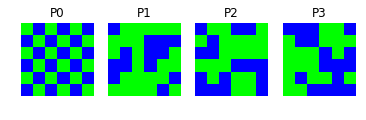

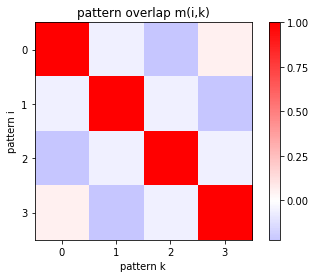

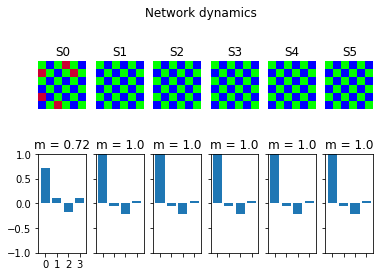

In [58]:
%matplotlib inline
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
from matplotlib import rcParams
import numpy as np
np.random.seed(1)
#rcParams['figure.figsize'] = 10,10
pattern_size = 6

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=3, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)

# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=5)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=5)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

***Note:*** The network state is a vector of N neurons. For visualization we use 2d patterns which are two dimensional numpy.ndarrays of size = (length, width). To store such patterns, initialize the network with N = length x width neurons.

## 8.2. Introduction: Hopfield-networks

This exercise uses a model in which neurons are pixels and take the values of -1 (off) or +1 (on). The network can store a certain number of pixel patterns, which is to be investigated in this exercise. During a retrieval phase, the network is started with some initial configuration and the network dynamics evolves towards the stored pattern (attractor) which is closest to the initial configuration.

The dynamics is that of equation:
\begin{equation}
    S_i(t+1) = sgn\left(\sum_j w_{ij} S_j(t)\right)
\end{equation}
In the Hopfield model each neuron is connected to every other neuron (full connectivity). The connection matrix is
\begin{equation}
    w_{ij} = \frac{1}{N}\sum_{\mu} p_i^\mu p_j^\mu
\end{equation}
where N is the number of neurons, $p^{\mu}_i$
 is the value of neuron $i$
 in pattern number $\mu$
 and the sum runs over all patterns from $\mu=1$
 to $\mu=P$. This is a simple correlation based learning rule (Hebbian learning). Since it is not a iterative rule it is sometimes called one-shot learning. The learning rule works best if the patterns that are to be stored are random patterns with equal probability for on (+1) and off (-1). In a large networks (N to infinity) the number of random patterns that can be stored is approximately 0.14 times N.



## 8.3. Exercise: N=6x6 Hopfield-network

We study how a network stores and retrieve patterns. Using a small network of only 36 neurons allows us to have a close look at the network weights and dynamics.

### 8.3.1. Question: Storing a single pattern
#### [2 + 2 + 3 points]

Modify the Python code given above to implement this exercise:

Create a network with N=36 neurons.
Create a single 6 by 6 checkerboard pattern.
Store the checkerboard in the network.
Set the initial state of the network to a noisy version of the checkerboard (nr_flipped_pixels = 5).
Let the network dynamics evolve for 5 iterations.
Plot the sequence of network states along with the overlap of network state with the checkerboard.
Now test whether the network can still retrieve the pattern if we increase the number of flipped pixels. 

In [72]:
# Convenience function to play around with the effect of adjusting amount of bits flips in initial pattern
def plot_with_flip(flips):
    noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=flips)
    hopfield_net.set_state_from_pattern(noisy_init_state)
    states = hopfield_net.run_with_monitoring(nr_steps=5)
    states_as_patterns = factory.reshape_patterns(states)
    plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics with " + str(flips) +" flips")

In [77]:
np.random.seed(1)
pattern_size = 6

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard,checkerboard]

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

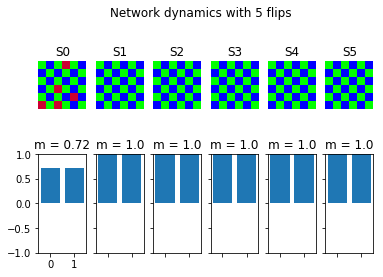

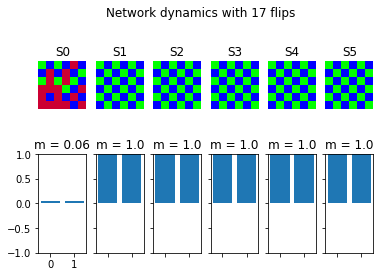

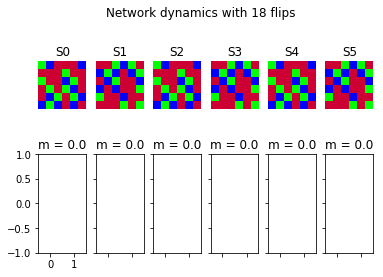

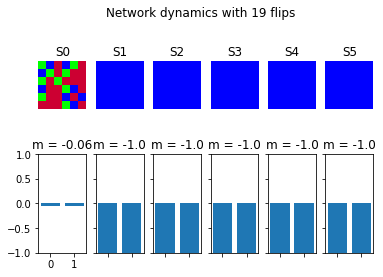

In [78]:
plot_with_flip(5)
plot_with_flip(17)
plot_with_flip(18)
plot_with_flip(19)

What happens at nr_flipped_pixels = 18, what if nr_flipped_pixels > 18 ?

#### your answer
* n < 18 has the network converge to the attractor in one step
* n = 18 has the pattern fail to create any overlap no matter how many iterations it is run since it just cycles between two equally faulty states.
* n > 18 has the network converge to complete inactivation

### 8.3.2. Question: the weights matrix
#### [1 + 3 + 2 points]

The patterns a Hopfield network learns are not stored explicitly. Instead, the network learns by adjusting the weights to the pattern set it is presented during learning. Let’s visualize this.

1. Create a new 6x6 network. Do not yet store any pattern.
2. What is the size of the network matrix?
3. Visualize the weight matrix using the function [`plot_tools.plot_nework_weights()`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#neurodynex.hopfield_network.plot_tools.plot_nework_weights). It takes the network as a parameter.
4. Create a checkerboard, store it in the network.
5. Plot the weights matrix. What weight values do occur?
6. Create a new 6x6 network
7. Create an L-shaped pattern (look at the pattern factory doc), store it in the network
8. Plot the weights matrix. What weight values do occur?
9. Create a new 6x6 network
10. Create a checkerboard and an L-shaped pattern. Store both patterns in the network
11. Plot the weights matrix. What weight values do occur? How does this matrix compare to the two previous matrices?

***Note:*** The mapping of the 2 dimensional patterns onto the one dimensional list of network neurons is internal to the implementation of the network. You cannot know which pixel (x,y) in the pattern corresponds to which network neuron i.

In [ ]:
# write your code here: Bullet points 1-5 

In [ ]:
# write your code here: Bullet points 6-11

How does this matrix compare to the two previous matrices?

your answer

### 8.3.3. Question: Weights Distribution
#### *** Note:*** this exercise is NOT a bonus and it is graded
#### [2 points]

It’s interesting to look at the weights distribution in the three previous cases. You can easily plot a histogram by adding the following two lines to your script. It assumes you have stored your network in the variable ‘hopfield_net’. Explain the observed distribution (max 3 lines).

In [ ]:
plt.figure()
plt.hist(hopfield_net.weights.flatten())

your answer

## 8.4. Exercise: Capacity of an N=100 Hopfield-network

Larger networks can store more patterns. There is a theoretical limit: the capacity of the Hopfield network. Read chapter [“17.2.4 Memory capacity”](http://neuronaldynamics.epfl.ch/online/Ch17.S2.html) to learn how memory retrieval, pattern completion and the network capacity are related.

### 8.4.1. Question:
#### [2 points]

A Hopfield network implements so called associative or content-adressable memory. Explain what this means. (max 4 lines)

your answer

### 8.4.2. Question:
#### [1 points]

Using the value $C_{store}$
 given in the book, how many patterns can you store in a N=10x10 network? Use this number K in the next question:

your answer 

### 8.4.3. Question:
#### [3+2 points]

Create an N=10x10 network and store a checkerboard pattern together with (K-1) random patterns. Then initialize the network with the unchanged checkerboard pattern. Let the network evolve for five iterations.

In [ ]:
# write your code here

Rerun your script a few times. What do you observe?

your answer

## 8.5. Exercise: Non-random patterns

In the previous exercises we used random patterns. Now we us a list of structured patterns: the letters A to Z. Each letter is represented in a 10 by 10 grid.

### 8.5.1. Question:

Run the following code. Read the inline comments and look up the doc of functions you do not know.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
import numpy

# the letters we want to store in the hopfield network
letter_list = ['A', 'B', 'C', 'S', 'X', 'Y', 'Z']

# set a seed to reproduce the same noise in the next run
# numpy.random.seed(123)

abc_dictionary =pattern_tools.load_alphabet()
print("the alphabet is stored in an object of type: {}".format(type(abc_dictionary)))
# access the first element and get it's size (they are all of same size)
pattern_shape = abc_dictionary['A'].shape
print("letters are patterns of size: {}. Create a network of corresponding size".format(pattern_shape))
# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_shape[0]*pattern_shape[1])

# create a list using Pythons List Comprehension syntax:
pattern_list = [abc_dictionary[key] for key in letter_list ]
plot_tools.plot_pattern_list(pattern_list)

# store the patterns
hopfield_net.store_patterns(pattern_list)

# # create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.get_noisy_copy(abc_dictionary['A'], noise_level=0.2)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=4)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = pattern_tools.reshape_patterns(states, pattern_list[0].shape)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(
    states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

### 8.5.2. Question:
#### [2 + 3 points]

Add the letter ‘R’ to the letter list and store it in the network.

In [ ]:
# write your code here

Is the pattern ‘A’ still a fixed point? Does the overlap between the network state and the reference pattern ‘A’ always decrease? (max 3 lines)

### 8.5.3. Question:
#### [3 + 3 points]

Make a guess of how many letters the network can store. Then create a (small) set of letters. Check if all letters of your list are fixed points under the network dynamics. 

In [ ]:
# write your code here

Explain the discrepancy between the network capacity C (computed above) and your observation. (max 4 lines)

your answer

## 8.6 Low activity attractor network

Hopfield networks are a useful abstraction in order to understand how associative memory works. 
However they are quite far from biological plausibility. One step towards a more bioplausible attractor network is to consider sparse patterns. In the traditional Hopfield network you have analysed so far, each pattern counts 50% of active units, now we consider patterns that only have a small fraction `f` of active units. 

A simple low activity attractor network is described in this [paper](https://www.mitpressjournals.org/doi/full/10.1162/NECO_a_00499) ("Scaling Laws of Associative Memory Retrieval" by Sandro Romani, Itai Pinkoviezky, Alon Rubin and Misha Tsodyks). 
The goal of this exercise is to understand the network model proposed in the first part of the paper and reproduce Fig.1.

Start by reading the introduction, ***section 2.1*** and ***A.1*** of the paper (that's all you'll need for the exercise).

***Note:*** In what follows we stick to the same notation of the paper. If you are confused about the meaning of a variable, you know were to find it!

### 8.6.1 Patterns and weight matrix
#### [1 + 2 + 2  points]

Start by implementing L sparse patterns. You can store them into a $L\times P$ matrix called `items`. In what follows, use the indications given in the comments.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Initialize the parameters like in the paper ## 
N = ???
L = ???
f = ???
T = ???
Dth = ???
Tth = ???
TJ0 = ???
min_J0 = ???
max_J0 = ???
timesteps = ???  ## for this one, check out Fig.1
np.random.seed(26) ## KEEP THE SEED FIXED FOR CORRECTION ##

In [ ]:
## Initialize patterns and weights (!!! for loops = -1 point !!!)

items = ??? ## find the right probability distibution within the numpy.random library
## Check that items has the right shape
print "Shape of items",  np.shape(items)

J = ??? ## implement the definition of the weight matrix, find the right numpy function for matrix multiplication
## Check that J has the right shape
print "Shape of items",  np.shape(J)

Explain why we need to subtract `f` in the weight formula. (max 5 lines)
#### [4 points]

your answer

Now initialize the threshold.
#### [2  points]

In [ ]:
## Initilize the thtrshold
thresh = ??? ## find the right probability distibution within the numpy.random library
thresh_0 = thresh.copy()  

### 8.6.2 Dynamical evolution
Now implement a function that let the state of the system evolve (for Fig.1A) and a second one which computes the overlaps between items (for Fig.1B) (use again the right numpy function for matrix multiplication and check out a numpy function for $\Theta$).

***Note:*** Don't confuse the overlap between the current state and the stored patterns and the overlap between patterns.
#### [4 + 1 points]

In [ ]:
def evolve(V_,thresh_,J0_):
    overlap_ = ??? ## write the overlap formula at time t 
    V_old = ??? 
    V_ = ???       ## write the update formula for time t+1
    thresh_ += ??? ## update the threshold for time t+1
    return V_,thresh_, overlap_

def overlap_mat(a,b):
    return ???    ## if a and b are two patterns, what's the overlap between them?

Run the dynamics and plot $J_0(t)$.
#### [4 + 1  points]

In [ ]:
## Here we prepare a dictionary in which to store the state, J0, threshold and overlap for each time step ## 
dic_evolution = {}
dic_evolution['J0'] = []
dic_evolution['V'] = []
dic_evolution['thresh'] = []
dic_evolution['overl'] = []

## Set the initial state of the matrix equal to the first pattern
V = ???

## Now we are ready to run the dynamics 
for i in range(timesteps):
    J0 = ??? ## use numpy.sin() to have the correct osclillatory behavior. Don't forget to scale it correctly
    ??? = evolve(???)
    
    dic_evolution['J0'] += ???
    dic_evolution['V'] += ???
    dic_evolution['thresh'] += ???
    dic_evolution['overl'] += ???

In [ ]:
## check that you have the right evolution of J0
plt.plot(???)
plt.xlim([0,???])  ## plot for one period
plt.show()

### 8.6.3 Plot the figures
#### [2 + 4 points]

In [ ]:
## Plot Fig. 1A 
plt.figure( ??? ) ## check out the inputs, how do you fix the figure size?
plt.imshow( ??? , interpolation = 'None', aspect = 'auto', cmap = 'jet') ## Insert the right dictionary 
## add a colorbar here
plt.show()

In [ ]:
## Plot Fig. 1B
## first you need to create a matrix filled with the overlaps between patterns.
overlap_matrix = ??? ## declare a matrix of 0s with the right shape. One more time, numpy is going to be useful.
for i in range( ??? ):
    for j in range(i, ??? ):
        if i != j:
            overlap_matrix[i,j] = overlap_matrix[j,i] = ??? ## insert the right expression for the element of overlap_matrix
            
## Set the diagonal of overlap_matrix = to average of other entries ## 
overlap_matrix = ??? 
plt.imshow( ??? , aspect='auto',cmap='jet')
## add a colorbar here
plt.show()

Comment your first figure: do you notice any recurrence in the item retrieval? How do they interpret it in the paper? 
Now explain the link between the first and the second figure. (max 12 lines)
#### [8 points]

your answer